### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#imports
import scipy.io
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import obspy
import pywt
import pywt.data

### Load the trimmed data 

In [3]:
path = "/Users/ecem/Desktop/phonocardiogram/data/TV/absent"
path_w = "/Users/ecem/Desktop/phonocardiogram/data/TV/absent/wavelet"
waves = np.load(path + "/absent_TV_waves_10sec.npy", allow_pickle= True)

In [4]:
n= waves.shape[0]

In [5]:
n

5718

## Let's look at wavelet decomposition for a signal piece

#### how our decomposition filter values look like

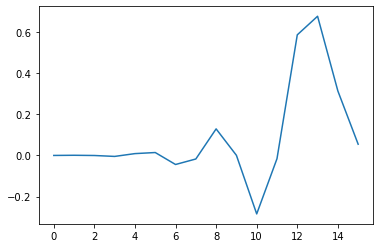

In [6]:
w = pywt.Wavelet('db8')
plt.plot(w.dec_lo)
coeffs = pywt.wavedec(waves[0], w, level=6)

In [7]:
import pandas as pd

In [8]:
coef = []
for i in range(len(waves)):
    coef.append(pywt.wavedec(waves[i], w, level=5))

In [9]:
for i in range(6):
    print(coef[0][i].shape)

(1264,)
(1264,)
(2514,)
(5013,)
(10011,)
(20007,)


### Level by level

In [10]:
def level_coef_extractor_3d(array, lvl = 0):
    array =np.array(array)
    
    lenn = array[0][lvl].shape[0] #48
    coef = np.ones(shape = (array.shape[0],lenn)) #2392,48
    
    for i in range(array.shape[0]):
        coef[i,:] = array[i][lvl]
        
    return coef

In [11]:
def saver(array = 0, lvl = 0, dir_path = None, name = 'blank'):
    coefs = level_coef_extractor_3d(array, lvl)
    np.save(dir_path + "/"+ str(name) + "_lvl_"  + str(lvl), coefs, allow_pickle = True)
    del coefs

In [12]:
for i in range(6):
    saver(coef, i, path_w, 'absent_PV_wavelet_coef_5')


## Shannon entropy

The core idea of information theory is that the "informational value" of a communicated message depends on the degree to which the content of the message is surprising. 

If a highly likely event occurs, the message carries very little new information. On the other hand, if a highly unlikely event occurs, the message is much more informative. For instance, the knowledge that some particular number will not be the winning number of a lottery provides very little information, because any particular chosen number will almost certainly not win. 

However, knowledge that a particular number will win a lottery has high informational value because it communicates the outcome of a very low probability event.

There is therefore an inverse relationship between information and the probability of occurrence

Remember that Shannon Entropy works on sequences (or probability distribution built from sequences) therefore, you need to have an historic already built up of what your sequence of interest looks like.

In [13]:
import scipy.stats

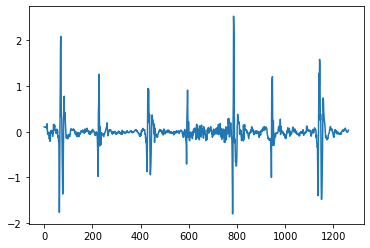

In [14]:
plt.plot(coef[0][0])

In [15]:
def scale(data): #1264
    maxx = data.max()
    minn = data.min()
    
    diff = maxx - minn
    scaled = np.empty((data.shape[0]))
    
    for i in range(data.shape[0]):
        scaled[i] = (data[i] - minn )/ diff
    return scaled

In [16]:
len(coef[0][0]) #1245,6,1264

1264

In [17]:
def scaled_wavelet(array, lvl = 6):
    all_wavelets = []
    
    for i in range(lvl):
        lenn = array[0][i].shape[0] #level uzunluğu alıyor
        scaled_lvl = np.empty((array.shape[0], lenn)) # 1245, level uzunluğu kadar array oluşturuyor
        
        for j in range(array.shape[0]): #1245
            scaled_lvl[j,:] = scale(coef[j][i])  
            
        all_wavelets.append(scaled_lvl)
    return all_wavelets

In [18]:
coef = np.array(coef)
wavelets = scaled_wavelet(coef)

In [19]:
len(wavelets[0][0]) # 6, 1245, 1264

1264

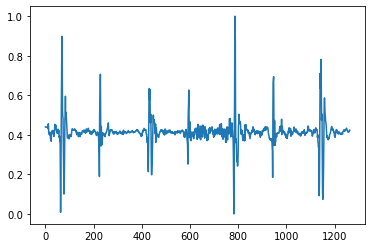

In [20]:
plt.plot(wavelets[0][0])

In [21]:
ent = np.empty((n, 6))
for j in range(6):
    for i in range(n):#1245
        ent[i, j] = scipy.stats.entropy(wavelets[j][i])

In [22]:
ent

array([[7.12875919, 7.14039583, 7.82798375, 8.51863246, 9.21106889,
        9.90376153],
       [7.12762208, 7.13585469, 7.8268504 , 8.51538886, 9.20871785,
        9.90355239],
       [7.12778189, 7.13896062, 7.82600458, 8.51788179, 9.20939726,
        9.90368406],
       ...,
       [7.13056764, 7.13559966, 7.79238669, 8.49352449, 9.19254503,
        9.90371039],
       [7.1384477 , 7.13916101, 7.82854862, 8.47875242, 9.20596179,
        9.90374429],
       [7.13597643, 7.13902726, 7.82829822, 8.51896341, 9.21085383,
        9.90376969]])

In [23]:
ent_df = pd.DataFrame(ent, columns = ["approx","lvl5", "lvl4", "lvl3", "lvl2", "lvl1"])
ent_df

,approx,lvl5,lvl4,lvl3,lvl2,lvl1
0,7.128759,7.140396,7.827984,8.518632,9.211069,9.903762
1,7.127622,7.135855,7.826850,8.515389,9.208718,9.903552
2,7.127782,7.138961,7.826005,8.517882,9.209397,9.903684
3,7.125478,7.140616,7.828822,8.519336,9.210906,9.903748
4,7.128550,7.133429,7.819289,8.515996,9.206467,9.903670
...,...,...,...,...,...,...
5713,7.140428,7.140562,7.828294,8.518869,9.208954,9.903689
5714,7.137012,7.139455,7.808572,8.500026,9.204949,9.903756
5715,7.130568,7.135600,7.792387,8.493524,9.192545,9.903710
5716,7.138448,7.139161,7.828549,8.478752,9.205962,9.903744


In [24]:
ent_df.to_csv(path_w + "shannon_entropy_TV.csv")